In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

overwrite_figures = True

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
files = glob.glob('/home/trevor/repos/MUSiK/demos/breast/breast_3D_planewave_net/results/intermediate_image_000*.npz')
test = utils.load_array(files[0])
for file in tqdm.tqdm(files[1:]):
    test = test + utils.load_array(file)

In [6]:
test.shape

(148, 176, 189)

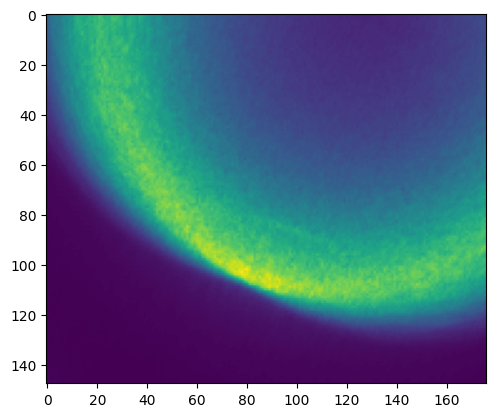

In [21]:
plt.imshow(test[:,:,90])

In [5]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.25e-3,0.25e-3,0.25e-3),
            matrix_dims = (256,256,128),
            baseline = (1540, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1540, rho=1000, sigma=5, scale=0.0001, label=0)
t1 = tissue.Tissue(name='t1', c=1540, rho=1000, sigma=0, scale=0.0001, label=1)
t2 = tissue.Tissue(name='t2', c=1540, rho=1000, sigma=15, scale=0.0001, label=2)
t3 = tissue.Tissue(name='t3', c=1540, rho=1000, sigma=30, scale=0.0001, label=3)
t4 = tissue.Tissue(name='t4', c=1540, rho=1000, sigma=45, scale=0.0001, label=4)
t5 = tissue.Tissue(name='t5', c=1540, rho=1000, sigma=60, scale=0.0001, label=5)

pos = 0.008
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

test_phantom.add_tissue_sphere((0,-2*pos,0), 8, t1)
test_phantom.add_tissue_sphere((0,-pos,0), 8, t2)
test_phantom.add_tissue_sphere((0,0,0), 8, t3)
test_phantom.add_tissue_sphere((0,pos,0), 8, t4)
test_phantom.add_tissue_sphere((0,2*pos,0), 8, t5)
test_phantom.add_tissue_sphere((2*pos,-2*pos,0), 12, t5)
test_phantom.add_tissue_sphere((2*pos,-pos,0), 12, t4)
test_phantom.add_tissue_sphere((2*pos,0,0), 12, t3)
test_phantom.add_tissue_sphere((2*pos,pos,0), 12, t2)
test_phantom.add_tissue_sphere((2*pos,2*pos,0), 12, t1)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

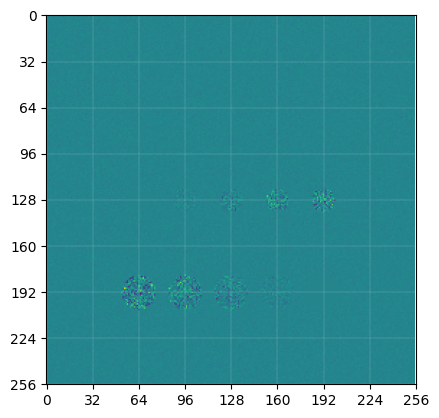

In [6]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [7]:
import math

def fibonacci_sphere(samples=1000, maxphi=2*np.pi):
    coords = []
    angles = []
    phi = math.pi * (math.sqrt(5.) - 1.)
    for i in range(samples):
        x = -1 + (i / float(samples - 1)) * 2  * maxphi / (2 * np.pi)
        radius = math.sqrt(1 - x * x)
        theta = phi * i
        y = math.cos(theta) * radius
        z = math.sin(theta) * radius
        coords.append((x, y, z))
        angles.append((math.acos(x), -np.pi, theta % (np.pi * 2) - np.pi))
    return np.array(coords), np.array(angles)

def simple_cone(samples=1000, maxphi=2*np.pi):
    coords = []
    angles = []
    phi = math.pi * (math.sqrt(5.) - 1.)
    for i in range(samples):
        # x = -1 + (i / float(samples - 1)) * 2  * maxphi / (2 * np.pi)
        x = -1 + maxphi /  (np.pi)
        radius = math.sqrt(1 - x * x)
        theta = 2 * np.pi * i / samples
        y = math.cos(theta) * radius
        z = math.sin(theta) * radius
        coords.append((x, y, z))
        angles.append((math.acos(x), -np.pi, theta % (np.pi * 2) - np.pi))
    return np.array(coords), np.array(angles)

In [34]:
num_transducers = 400
# transducers = [transducer.Focused(max_frequency=1e6,
#                                     elements = 8, 
#                                     width = 20e-3,
#                                     height =  10e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = (np.pi/4,np.pi/4),
#                                     ray_num = (2,2),
#                                     imaging_ndims = 3,
#                                     focus_azimuth = float('inf'),
#                                     focus_elevation = float('inf'),
#                                     ) for i in range(num_transducers)]
transducers = [transducer.Focused(max_frequency=1e6,
                                    elements = 1, 
                                    width = 1e-3,
                                    height =  1e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = (0,0),
                                    ray_num = (1,1),
                                    imaging_ndims = 3,
                                    focus_azimuth = float('inf'),
                                    focus_elevation = float('inf'),
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])
    
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [35]:
coords, angles = fibonacci_sphere(num_transducers, maxphi=np.pi / 2)

# coords0, angles0 = simple_cone(8, maxphi=np.pi / 8) 
# coords2, angles2 = simple_cone(16, maxphi=np.pi/2)
# coords = np.concatenate((coords0, coords2))
# angles = np.concatenate((angles0, angles2))

for i,(coord,angle) in enumerate(zip(coords, angles)):
    test_transducer_set.assign_pose(i, geometry.Transform(angle, coord * 0.04, intrinsic=False))

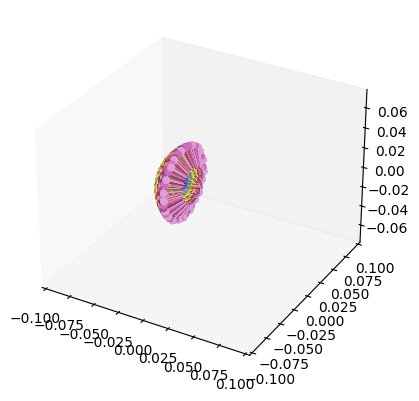

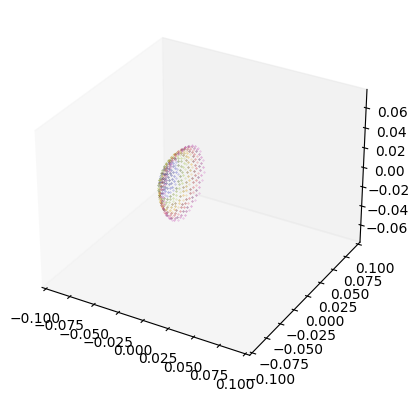

In [37]:
# cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
# count = 0
# spacing = 0.005
# for i in np.linspace(-dim[0]/2,dim[0]/2,dim[0]):
#     for j in np.linspace(-dim[1]/2,dim[1]/2,dim[1]):
#         cont_transducer_set.assign_pose(count, geometry.Transform([0,0,0], [-0.025, spacing*i, spacing*j]))
#         count += 1
        
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [38]:
extended_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

In [39]:
simprops = simulation.SimProperties(
                grid_size   = (60e-3,50e-3,50e-3),
                PML_size    = (16,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [40]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'spherical_tomography_test_3d',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

extended_experiment.save()

[Text(0, 0, '0.064'), Text(0, 256, '0')]

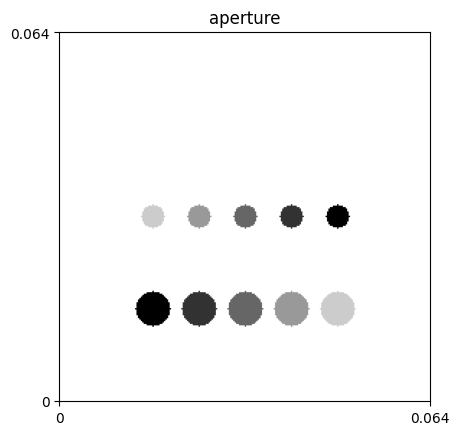

In [41]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])
plt.gca().set_title('aperture')
plt.gca().set_xticks([-1,256])
plt.gca().set_xticklabels(['0','0.064'])
plt.gca().set_yticks([0,256])
plt.gca().set_yticklabels(['0.064','0'])
# plt.savefig('contrast_phantom.png', dpi=300, bbox_inches="tight")

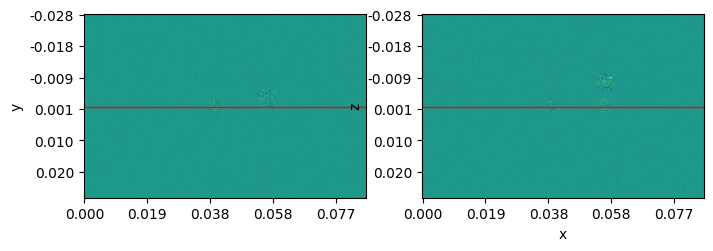

In [42]:
extended_experiment.plot_ray_path(10)

In [44]:
test_experiment = experiment.Experiment.load('spherical_tomography_test_3d')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

Number of simulation results (96) is less than the expected number of simulation results (400), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 400/400 [00:45<00:00,  8.72it/s]

running with 2 workers



preparation for sim    0 completed in  7.45 seconds
simulation             0 completed in  9.38 seconds
preparation for sim    1 completed in  8.43 seconds
preparation for sim    2 completed in  7.93 seconds
simulation             1 completed in  8.68 seconds
simulation             2 completed in  9.34 seconds
preparation for sim    3 completed in  8.12 seconds
simulation             3 completed in  8.85 seconds
preparation for sim    4 completed in  7.98 seconds
preparation for sim    5 completed in  8.11 seconds
simulation             4 completed in  9.87 seconds
preparation for sim    6 completed in  7.99 seconds
simulation             5 completed in  8.95 seconds
preparation for sim    7 completed in  8.09 seconds
simulation             6 completed in  9.34 seconds
preparation for sim    8 completed in  7.95 seconds
simulation             7 completed in  9.01 seconds
preparation for sim    9 completed in  7.99 seconds
simulation             8 completed in  9.88 seconds
preparation 

# Reconstruction

In [8]:
test_experiment = experiment.Experiment.load('spherical_tomography_test_3d')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 400/400 [00:46<00:00,  8.65it/s]


In [9]:
# images1 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False, attenuation_factor=8)
images1 = test_reconstruction.compound(workers=16, resolution_multiplier=1, combine=False, attenuation_factor=12, volumetric=True)

100%|██████████| 400/400 [00:00<00:00, 560923.30it/s]


running reconstruction on ray 0
running reconstruction on ray 1
running reconstruction on ray 2
running reconstruction on ray 3
running reconstruction on ray 7
running reconstruction on ray 4
running reconstruction on ray 5
running reconstruction on ray 8
running reconstruction on ray 6
running reconstruction on ray 9
running reconstruction on ray 14
running reconstruction on ray 10
running reconstruction on ray 15
running reconstruction on ray 11
running reconstruction on ray 16
running reconstruction on ray 12
running reconstruction on ray 21
running reconstruction on ray 17
running reconstruction on ray 13
running reconstruction on ray 22
running reconstruction on ray 18
running reconstruction on ray 19
running reconstruction on ray 23
running reconstruction on ray 20
running reconstruction on ray 28
running reconstruction on ray 24
running reconstruction on ray 29
running reconstruction on ray 25
running reconstruction on ray 26
running reconstruction on ray 30
running reconstructi

In [10]:
image1 = np.sum(images1, axis=0)/len(images1)
image1t1 = np.sum(images1[:len(images1)//3], axis=0)/(len(images1)//3)
image1t2 = np.sum(images1[len(images1)//3:2*len(images1)//3], axis=0)/(len(images1)//3)
image1t3 = np.sum(images1[2*len(images1)//3:], axis=0)/(len(images1)//3)

In [11]:
from scipy.interpolate import NearestNDInterpolator
sensormask = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(sensormask.shape[0])):
    for j in range(sensormask.shape[1]):
        x.append(i)
        y.append(j)
        z.append(sensormask[i,j,:].sum(axis=-1))
X = np.linspace(0, sensormask.shape[0], image1.shape[0])
Y = np.linspace(0, sensormask.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,114:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:114] = 0
sensor_mask2[:,228:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:228] = 0

100%|██████████| 256/256 [00:00<00:00, 2477.68it/s]


[]

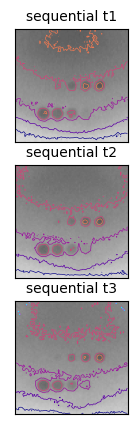

In [12]:
fig, ax = plt.subplots(3,1, figsize=(2.5,5))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image1t1 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[0].set_title('sequential t1', fontsize=10)

psf = 20 * np.log10(image1t2 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[1].set_title('sequential t2', fontsize=10)

psf = 20 * np.log10(image1t3 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[2].set_title('sequential t3', fontsize=10)

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
# if overwrite_figures:
#     plt.savefig('sequential_aperture_individual_contrast.png', dpi=300, bbox_inches="tight")

[]

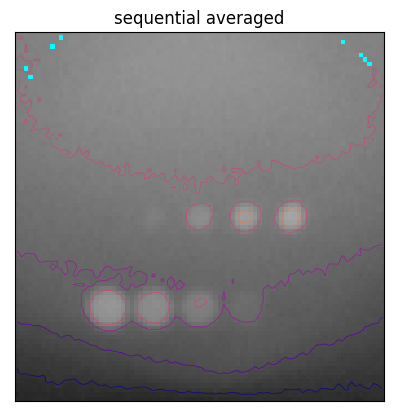

In [13]:
psf = 20 * np.log10(image1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-100, vmax=-50)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])

ax.set_title('sequential averaged')

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
# if overwrite_figures:
#     plt.savefig('sequential_aperture_contrast.png', dpi=300, bbox_inches="tight")

In [14]:
# assert False
image1.shape

(84, 84, 42)

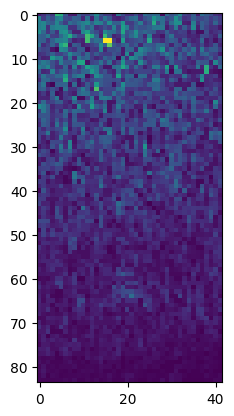

In [22]:
plt.imshow(images1[50][:, image1.shape[1]//2, :])

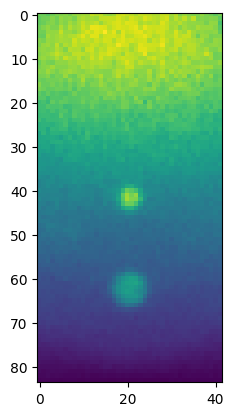

In [16]:
plt.imshow(image1[:, image1.shape[1]//2, :])

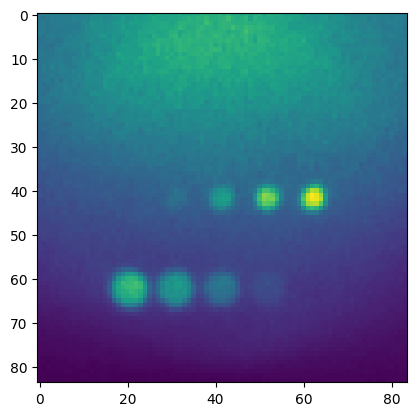

In [17]:
plt.imshow(image1[:,:,21])